In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
cat = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/spectro/daily/main_done_cumulative_lrg_good_20211027.fits'))
print(len(cat))

153297


In [4]:
# cat['EFFTIME_ELG'] = 8.60 * cat['TSNR2_ELG']
cat['EFFTIME_LRG'] = 12.15 * cat['TSNR2_LRG']

# Remove FIBERSTATUS!=0 fibers
mask = cat['COADD_FIBERSTATUS']==0
print('FIBERSTATUS',np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
cat = cat[mask]

# Remove "no data" fibers
mask = cat['ZWARN'] & 2**9==0
print('No data', np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
cat = cat[mask]

# Apply LRG mask
mask = cat['lrg_mask']==0
print('LRG mask', np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
cat = cat[mask]

# Remove QSO targets
mask = cat['DESI_TARGET'] & 2**2 ==0
print('Remove QSO targets', np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
cat = cat[mask]

# Require a minimum depth
min_depth = 800.
mask = cat['EFFTIME_LRG']>min_depth
print('Min depth', np.sum(mask), np.sum(~mask), np.sum(mask)/len(mask))
cat = cat[mask]

# Julien's bad fibers list
bad_fibers = np.array(Table.read('/global/cfs/cdirs/desi/users/rongpu/spectro/everest/misc/badfibers.csv')['FIBER'])
# bad_fibers = np.array(Table.read('/Users/rongpu/Documents/Data/desi_data/everest/misc/badfibers.csv')['FIBER'])
bad_fibers = np.append(bad_fibers, np.arange(2663, 2674+1))  # fibers affected by the CCD z5 defect
bad_fibers = np.append(bad_fibers, [3402, 3429])  # "swapped" fibers
bad_fibers = np.unique(bad_fibers)
print(len(bad_fibers), 'bad fibers')
mask_bad = np.in1d(cat['FIBER'], bad_fibers)
print('Bad fibers', np.sum(~mask_bad), np.sum(mask_bad), np.sum(mask_bad)/len(mask_bad))
cat = cat[~mask_bad]

# Remove duplidates keeping the higher EFFTIME objects
print(len(cat), len(np.unique(cat['TARGETID'])), len(cat)-len(np.unique(cat['TARGETID'])))
cat.sort('EFFTIME_LRG', reverse=True)
_, idx_keep = np.unique(cat['TARGETID'], return_index=True)
cat = cat[idx_keep]
print(len(cat), len(np.unique(cat['TARGETID'])), len(cat)-len(np.unique(cat['TARGETID'])))

print(len(cat))

FIBERSTATUS 151843 1454 0.009484856194185144
No data 151840 3 1.9757249264042465e-05
LRG mask 138919 12921 0.08509615384615385
Remove QSO targets 137477 1442 0.010380149583570282
Min depth 125446 12031 0.9124871796736909
199 bad fibers
Bad fibers 120998 4448 0.03545748768394369
120998 118985 2013
118985 118985 0
118985


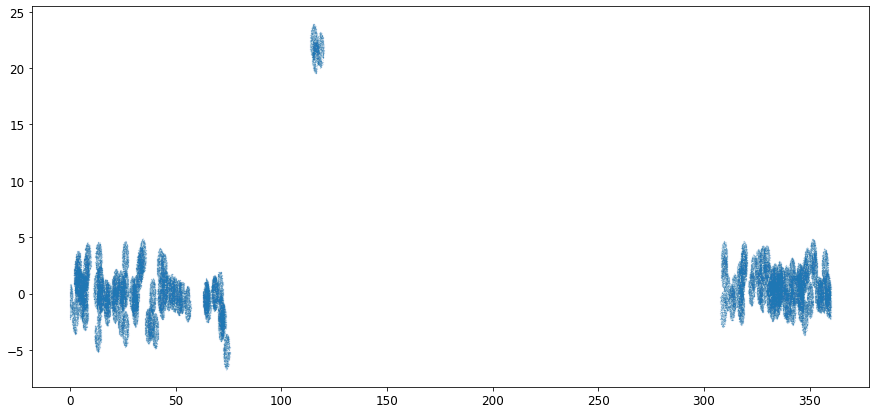

In [5]:
plt.figure(figsize=(15, 7))
plt.plot(cat['TARGET_RA'], cat['TARGET_DEC'], '.', ms=0.1)
plt.show()

In [6]:
mask = cat['TARGET_DEC']<15
cat = cat[mask]
print(len(cat))

116095


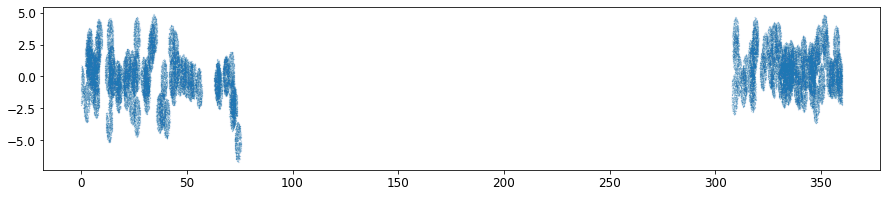

In [7]:
plt.figure(figsize=(15, 3))
plt.plot(cat['TARGET_RA'], cat['TARGET_DEC'], '.', ms=0.1)
plt.show()

In [8]:
cat

TARGETID,CHI2,Z,ZERR,ZWARN,SPECTYPE,DELTACHI2,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,FIBERASSIGN_X,FIBERASSIGN_Y,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FIBERFLUX_Z,MASKBITS,PARALLAX,PHOTSYS,DESI_TARGET,BGS_TARGET,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,TSNR2_ELG,TSNR2_BGS,TSNR2_QSO,TSNR2_LRG,lrg_mask,EFFTIME_LRG
int64,float64,float64,float64,int64,str6,float64,int16,int32,int64,int32,int32,float64,float64,float32,float32,str4,float32,float32,float32,float32,float32,float32,float32,int16,float32,str1,int64,int64,int32,int16,float32,int16,int16,float32,float32,float32,float32,int16,float32
39627623168479137,8118.13845942542,0.588345166319764,0.00011671982671914782,0,GALAXY,202.46787639334798,0,512,512,379,0,73.8116246381616,-6.647435732846417,68.95622,-385.2337,DEV,0.040858854,0.7722281,4.8481607,17.377594,49.6401,20.928076,4.409185,0,0.0,S,65537,0,4047,2,1519.7491,2,1,121.63376,7054.216,31.86334,79.69468,0,968.29034
39627623168479963,8080.798187538981,0.5444102595239455,8.545797989037349e-05,0,GALAXY,441.44056640565395,0,511,511,363,0,73.84588820841765,-6.6463225734789235,60.330067,-384.83163,SER,0.039381724,1.2126478,6.4470778,21.16424,62.75125,39.381393,7.102744,0,0.0,S,65537,0,4047,2,1519.7491,2,1,118.847595,6869.421,31.145851,77.63618,0,943.27954
39627623168481637,8000.4506699331105,0.5651774129218252,0.00012502324906919828,0,GALAXY,327.36232439801097,0,493,493,373,0,73.90849116186445,-6.644472192951504,44.589867,-384.18826,DEV,0.039953876,1.0321926,6.8978653,23.947992,71.677086,38.887455,5.3133216,0,0.0,S,65537,0,4047,2,1519.7491,2,1,121.52977,7003.1343,31.73093,79.08341,0,960.8634
39627623172672408,8902.687904424965,0.5819318605172296,7.336921197942945e-05,0,GALAXY,387.2973033413291,0,520,520,471,0,74.02561366219709,-6.734059198272475,15.317196,-408.62833,REX,0.04985346,1.099038,4.391287,13.062157,53.685024,31.223518,7.4153214,2048,0.0,S,65537,0,4047,2,1519.7491,2,1,111.35442,6493.413,28.943588,73.09382,0,888.08984
39627623176866524,8028.689357593656,0.7341358001662619,6.547558188679044e-05,0,GALAXY,343.4850427489728,0,446,446,308,0,74.2576351837235,-6.632621713326235,-42.992157,-381.14935,SER,0.041765958,1.8300921,5.2211175,17.451967,55.824482,37.574627,4.995431,0,0.0,S,65537,0,4047,2,1519.7491,2,1,122.0209,7037.384,31.97325,79.5444,0,966.4645
39627623176869847,8022.826147012413,0.5441591444840141,8.867518502483084e-05,0,GALAXY,250.91162569075823,0,463,463,319,0,74.36680130911006,-6.669198829062377,-70.53255,-391.52216,SER,0.04452625,1.1578428,6.449184,20.586193,51.174973,29.836008,5.9605947,0,0.0,S,65537,0,4047,2,1519.7491,2,1,112.65853,6554.811,29.375132,73.67532,0,895.15515
39627623181058312,8315.515962228179,0.5446569558378158,6.632559503450238e-05,0,GALAXY,1619.3605468906462,0,462,462,321,0,74.41995242862791,-6.687162295102643,-84.00883,-396.70187,SER,0.046795443,2.3613894,11.9984665,32.71402,67.39135,39.469418,13.223155,0,0.0,S,1152921504606912513,65537,4047,2,1519.7491,2,1,112.15514,6455.1885,29.133047,72.70126,0,883.3203
39627629162140643,8602.86323954165,0.5779465217925416,7.157632927746979e-05,0,GALAXY,815.6290609464049,1,519,1519,682,0,73.12442183940213,-6.40970804472701,242.21347,-325.90576,DEV,0.04286044,1.0304344,6.154225,21.61283,59.371323,38.58292,9.062672,0,0.0,S,65537,0,4047,2,1519.7491,2,1,110.60703,6882.6855,29.514183,76.209625,0,925.9469
39627629166330124,8105.256685629487,0.7373605282874239,8.917474663245779e-05,0,GALAXY,101.33465587126557,1,504,1504,676,0,73.16592275798882,-6.417340697128635,231.5302,-327.5249,DEV,0.04199114,0.85211134,3.1097934,11.470836,43.88176,23.77322,3.8091486,0,0.0,S,65537,0,4047,2,1519.7491,2,1,112.14697,6913.9287,29.989788,76.69632,0,931.8602


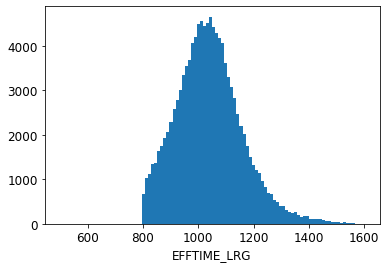

In [9]:
plt.hist(cat['EFFTIME_LRG'], 100, range=(500, 1600))
plt.xlabel('EFFTIME_LRG')
plt.show()

In [10]:
mask = (cat['EFFTIME_LRG']>800) & (cat['EFFTIME_LRG']<1200)
cat = cat[mask]
print(len(cat))

105640


In [11]:
mask = ~np.in1d(cat['PETAL_LOC'], [1, 4, 5, 8])
cat = cat[mask]
print(len(cat))
print(list(np.unique(cat['PETAL_LOC'])))

64123
[0, 2, 3, 6, 7, 9]


In [12]:
# Custom DELTACHI2 vs z cut
d = (10**(3 - 3.5*cat['Z']))
mask_remove = (d>30) & (cat['DELTACHI2']<30)
mask_remove |= (d<30) & (cat['DELTACHI2']<d)
mask_remove |= (cat['DELTACHI2']<10)
mask_quality = cat['ZWARN']==0
mask_quality &= cat['Z']<1.4
mask_quality &= (~mask_remove)

print(np.sum(~mask_quality)/len(mask_quality))

0.017029770909034198


In [13]:
cat['speed'] = cat['EFFTIME_LRG']*10**(2*2.165*cat['EBV']/2.5)/cat['COADD_EXPTIME']
cat['speed_noebv'] = cat['EFFTIME_LRG']/cat['COADD_EXPTIME']

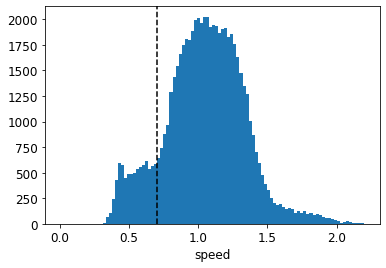

In [14]:
plt.hist(cat['speed'], 100, range=(0, 2.2))
plt.axvline(0.7, ls='--', color='k')
plt.xlabel('speed')
plt.show()

In [15]:
low_speed = cat['speed']<0.7
print(np.sum(low_speed), np.sum(low_speed)/len(low_speed))

high_speed = cat['speed']>0.7
print(np.sum(high_speed), np.sum(high_speed)/len(high_speed))

nominal_speed = (cat['speed']>0.7) & (cat['speed']<1.2)
print(np.sum(nominal_speed), np.sum(nominal_speed)/len(nominal_speed))

7777 0.12128253512780125
56346 0.8787174648721987
37135 0.5791213761052977


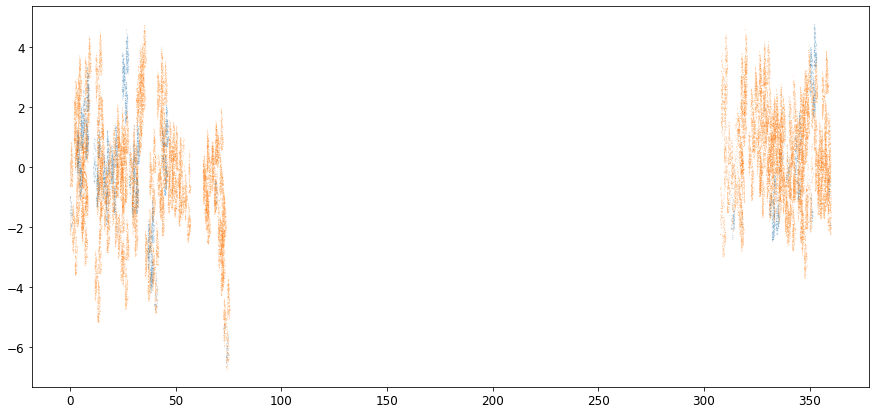

In [16]:
plt.figure(figsize=(15, 7))
plt.plot(cat['TARGET_RA'][low_speed], cat['TARGET_DEC'][low_speed], '.', ms=0.1)
plt.plot(cat['TARGET_RA'][~low_speed], cat['TARGET_DEC'][~low_speed], '.', ms=0.1)
plt.show()

In [17]:
print('low speed rejection rate:')
print(np.sum((~mask_quality) & low_speed)/np.sum(low_speed))
print('high speed rejection rate:')
print(np.sum((~mask_quality) & high_speed)/np.sum(high_speed))
print('nominal speed rejection rate:')
print(np.sum((~mask_quality) & nominal_speed)/np.sum(nominal_speed))

low speed rejection rate:
0.02815995885302816
high speed rejection rate:
0.015493557661590884
nominal speed rejection rate:
0.017799919213679818


In [18]:
print(np.median(cat['EBV'][low_speed]))
print(np.median(cat['EBV'][high_speed]))

0.03220907
0.048552625


In [19]:
def binned_frac(x, y, bin_edges, minsize=10, error_floor=True):
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    bin_frac = np.zeros(len(bin_edges)-1)
    bin_frac_err = np.zeros(len(bin_edges)-1)
    for index in range(len(bin_edges)-1):
        mask = (x>bin_edges[index]) & (x<=bin_edges[index+1])
        if np.sum(mask)<minsize:
            bin_frac[index] = np.nan
            bin_frac_err[index] = np.nan
        else:
            n, p = np.sum(mask), np.mean(y[mask])
            if error_floor:
                p1 = np.maximum(p, 1/n)  # error floor
            else:
                p1 = p
            bin_frac[index] = p
            bin_frac_err[index] = np.clip(np.sqrt(n * p * (1-p))/n, np.sqrt(n * p1 * (1-p1))/n, 1)
    
    return bin_center, bin_frac, bin_frac_err

In [20]:
bin_edges = np.linspace(0., 2, 21)
bin_edges

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])

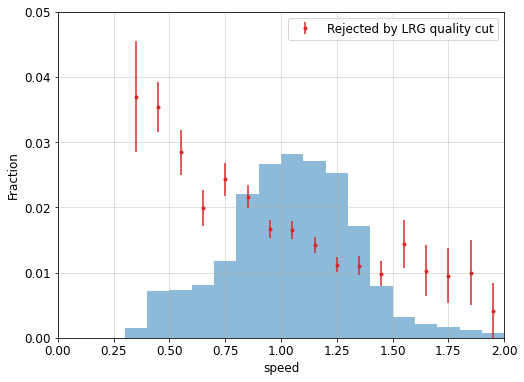

In [21]:
mask = np.full(len(cat), True)
bin_edges = np.linspace(0., 2, 21)
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(cat['speed'][mask], (~mask_quality)[mask], bin_edges, minsize=10)

plt.figure(figsize=(8, 6))
plt.errorbar(bin_center, bin_reject_rate, color='C3',
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label='Rejected by LRG quality cut')
plt.xlabel('speed')
plt.ylabel('Fraction')
plt.grid(alpha=0.5)
plt.legend(loc='upper right')
plt.axis([0.0, 2., 0., 0.05])
plt.hist(cat['speed'], bins=bin_edges, weights=np.full(len(cat), 0.2*1/len(cat)), alpha=0.5)
plt.show()

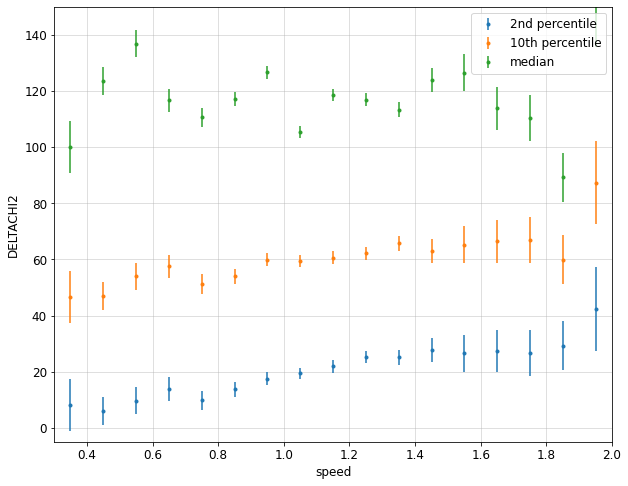

In [22]:
from scipy import stats

nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
error_of_the_mean = lambda x: nmad(x)/np.sqrt(len(x))
percentile1 = lambda x: np.percentile(x, 2)
percentile2 = lambda x: np.percentile(x, 5)
percentile3 = lambda x: np.percentile(x, 10)
percentile4 = lambda x: np.percentile(x, 20)
percentile5 = lambda x: np.percentile(x, 50)

def binned_stats(x, y, bins, statistic):
    bin_median, bin_edges, binnumber = stats.binned_statistic(x, y, statistic=statistic, bins=bins)
    bin_error, _, _ = stats.binned_statistic(x, y, statistic=error_of_the_mean, bins=bins)    
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    return bin_center, bin_edges, bin_median, bin_error

mask = np.full(len(cat), True)
bin_edges = np.linspace(0., 2, 21)

plt.figure(figsize=(10, 8))
bin_center, bin_edges, bin_median, bin_error = binned_stats(cat['speed'][mask], cat['DELTACHI2'][mask], bin_edges, percentile1)
plt.errorbar(bin_center, bin_median, yerr=bin_error, fmt='.', label='2nd percentile')
# bin_center, bin_edges, bin_median, bin_error = binned_stats(cat['speed'][mask], cat['DELTACHI2'][mask], bin_edges, percentile2)
# plt.errorbar(bin_center, bin_median, yerr=bin_error, fmt='.', label='5th percentile')
bin_center, bin_edges, bin_median, bin_error = binned_stats(cat['speed'][mask], cat['DELTACHI2'][mask], bin_edges, percentile3)
plt.errorbar(bin_center, bin_median, yerr=bin_error, fmt='.', label='10th percentile')
# bin_center, bin_edges, bin_median, bin_error = binned_stats(cat['speed'][mask], cat['DELTACHI2'][mask], bin_edges, percentile4)
# plt.errorbar(bin_center, bin_median, yerr=bin_error, fmt='.', label='20th percentile')
bin_center, bin_edges, bin_median, bin_error = binned_stats(cat['speed'][mask], cat['DELTACHI2'][mask], bin_edges, percentile5)
plt.errorbar(bin_center, bin_median-100, yerr=bin_error, fmt='.', label='median')
plt.xlabel('speed')
plt.ylabel('DELTACHI2')
plt.grid(alpha=0.5)
plt.legend(loc='upper right')
plt.axis([0.3, 2.0, -5, 150])
# plt.hist(cat['speed'], bins=bin_edges, weights=np.full(len(cat), 0.2*1/len(cat)), alpha=0.5)
plt.show()

-------
# No EBV in speed calculation

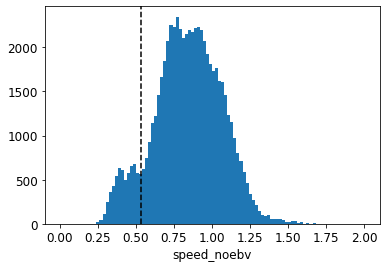

In [23]:
plt.hist(cat['speed_noebv'], 100, range=(0, 2))
plt.axvline(0.53, ls='--', color='k')
plt.xlabel('speed_noebv')
plt.show()

In [24]:
low_speed = cat['speed_noebv']<0.7
print(np.sum(low_speed), np.sum(low_speed)/len(low_speed))

high_speed = cat['speed_noebv']>0.7
print(np.sum(high_speed), np.sum(high_speed)/len(high_speed))

16177 0.2522807728896028
47946 0.7477192271103972


In [25]:
print('low speed rejection rate:')
print(np.sum((~mask_quality) & low_speed)/np.sum(low_speed))
print('high speed rejection rate:')
print(np.sum((~mask_quality) & high_speed)/np.sum(high_speed))

low speed rejection rate:
0.025344625084997217
high speed rejection rate:
0.014224335711008217


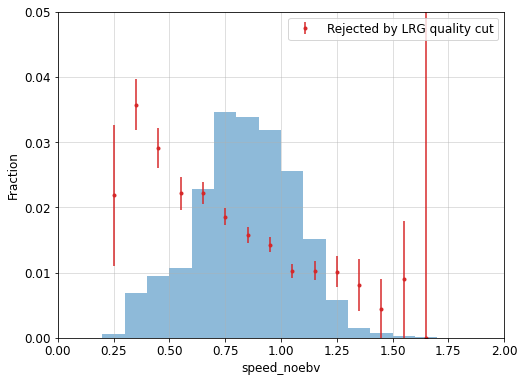

In [26]:
mask = np.full(len(cat), True)
bin_edges = np.linspace(0., 2, 21)
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(cat['speed_noebv'][mask], (~mask_quality)[mask], bin_edges, minsize=10)

plt.figure(figsize=(8, 6))
plt.errorbar(bin_center, bin_reject_rate, color='C3',
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label='Rejected by LRG quality cut')
plt.xlabel('speed_noebv')
plt.ylabel('Fraction')
plt.grid(alpha=0.5)
plt.legend(loc='upper right')
plt.axis([0.0, 2., 0., 0.05])
plt.hist(cat['speed_noebv'], bins=bin_edges, weights=np.full(len(cat), 0.2*1/len(cat)), alpha=0.5)
plt.show()

-------
# Split on EFFTIME

In [27]:
cat = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/spectro/daily/main_done_cumulative_lrg_good_20211027.fits'))
print(len(cat))

153297


In [28]:
# cat['EFFTIME_ELG'] = 8.60 * cat['TSNR2_ELG']
cat['EFFTIME_LRG'] = 12.15 * cat['TSNR2_LRG']

# Remove FIBERSTATUS!=0 fibers
mask = cat['COADD_FIBERSTATUS']==0
print('FIBERSTATUS',np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
cat = cat[mask]

# Remove "no data" fibers
mask = cat['ZWARN'] & 2**9==0
print('No data', np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
cat = cat[mask]

# Apply LRG mask
mask = cat['lrg_mask']==0
print('LRG mask', np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
cat = cat[mask]

# Remove QSO targets
mask = cat['DESI_TARGET'] & 2**2 ==0
print('Remove QSO targets', np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
cat = cat[mask]

# # Require a minimum depth
# min_depth = 700.
# mask = cat['EFFTIME_LRG']>min_depth
# print('Min depth', np.sum(mask), np.sum(~mask), np.sum(mask)/len(mask))
# cat = cat[mask]

# Julien's bad fibers list
bad_fibers = np.array(Table.read('/global/cfs/cdirs/desi/users/rongpu/spectro/everest/misc/badfibers.csv')['FIBER'])
# bad_fibers = np.array(Table.read('/Users/rongpu/Documents/Data/desi_data/everest/misc/badfibers.csv')['FIBER'])
bad_fibers = np.append(bad_fibers, np.arange(2663, 2674+1))  # fibers affected by the CCD z5 defect
bad_fibers = np.append(bad_fibers, [3402, 3429])  # "swapped" fibers
bad_fibers = np.unique(bad_fibers)
print(len(bad_fibers), 'bad fibers')
mask_bad = np.in1d(cat['FIBER'], bad_fibers)
print('Bad fibers', np.sum(~mask_bad), np.sum(mask_bad), np.sum(mask_bad)/len(mask_bad))
cat = cat[~mask_bad]

# Remove duplidates keeping the higher EFFTIME objects
print(len(cat), len(np.unique(cat['TARGETID'])), len(cat)-len(np.unique(cat['TARGETID'])))
cat.sort('EFFTIME_LRG', reverse=True)
_, idx_keep = np.unique(cat['TARGETID'], return_index=True)
cat = cat[idx_keep]
print(len(cat), len(np.unique(cat['TARGETID'])), len(cat)-len(np.unique(cat['TARGETID'])))

print(len(cat))

FIBERSTATUS 151843 1454 0.009484856194185144
No data 151840 3 1.9757249264042465e-05
LRG mask 138919 12921 0.08509615384615385
Remove QSO targets 137477 1442 0.010380149583570282
199 bad fibers
Bad fibers 132590 4887 0.03554776435331001
132590 125105 7485
125105 125105 0
125105


In [29]:
mask = cat['TARGET_DEC']<15
cat = cat[mask]
print(len(cat))

# mask = (cat['EFFTIME_LRG']>800) & (cat['EFFTIME_LRG']<1200)
# cat = cat[mask]
# print(len(cat))

mask = ~np.in1d(cat['PETAL_LOC'], [1, 4, 5, 8])
cat = cat[mask]
print(len(cat))
print(list(np.unique(cat['PETAL_LOC'])))

# Custom DELTACHI2 vs z cut
d = (10**(3 - 3.5*cat['Z']))
mask_remove = (d>30) & (cat['DELTACHI2']<30)
mask_remove |= (d<30) & (cat['DELTACHI2']<d)
mask_remove |= (cat['DELTACHI2']<10)
mask_quality = cat['ZWARN']==0
mask_quality &= cat['Z']<1.4
mask_quality &= (~mask_remove)

print(np.sum(~mask_quality)/len(mask_quality))

cat['speed'] = cat['EFFTIME_LRG']*10**(2*2.165*cat['EBV']/2.5)/cat['COADD_EXPTIME']

121908
74215
[0, 2, 3, 6, 7, 9]
0.019012329043993803


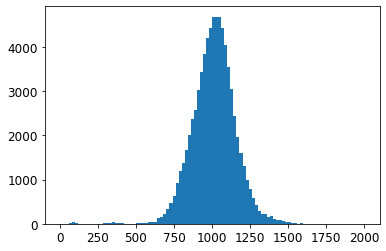

In [30]:
plt.hist(cat['EFFTIME_LRG'], 100, range=(0, 2000));

928.52374
1075.8485


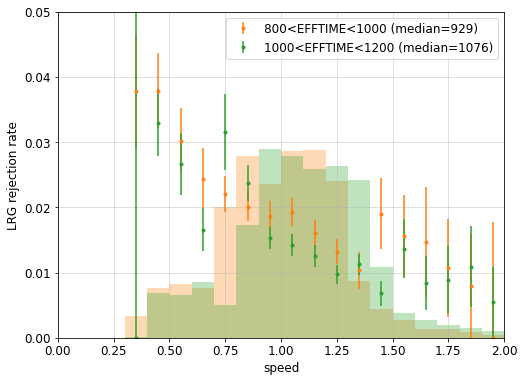

In [31]:
mask = (cat['EFFTIME_LRG']>800) & (cat['EFFTIME_LRG']<1200)

low_efftime = mask & (cat['EFFTIME_LRG']<1000)
high_efftime = mask & (cat['EFFTIME_LRG']>=1000)
print(np.median(cat['EFFTIME_LRG'][low_efftime]))
print(np.median(cat['EFFTIME_LRG'][high_efftime]))

bin_edges = np.linspace(0., 2, 21)

plt.figure(figsize=(8, 6))
mask = low_efftime.copy()
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(cat['speed'][mask], (~mask_quality)[mask], bin_edges, minsize=10)
plt.errorbar(bin_center, bin_reject_rate, color='C1',
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label='800<EFFTIME<1000 (median={:.0f})'.format(np.median(cat['EFFTIME_LRG'][low_efftime])))
plt.hist(cat['speed'][mask], bins=bin_edges, weights=np.full(np.sum(mask), 0.2*1/np.sum(mask)), alpha=0.3, color='C1')
mask = high_efftime.copy()
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(cat['speed'][mask], (~mask_quality)[mask], bin_edges, minsize=10)
plt.errorbar(bin_center, bin_reject_rate, color='C2',
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label='1000<EFFTIME<1200 (median={:.0f})'.format(np.median(cat['EFFTIME_LRG'][high_efftime])))
plt.hist(cat['speed'][mask], bins=bin_edges, weights=np.full(np.sum(mask), 0.2*1/np.sum(mask)), alpha=0.3, color='C2')
plt.xlabel('speed')
plt.ylabel('LRG rejection rate')
plt.grid(alpha=0.5)
plt.legend(loc='upper right')
plt.axis([0.0, 2., 0., 0.05])
plt.show()

15561 0.20967459408475375
37236 0.5017314559051405
21418 0.2885939500101058


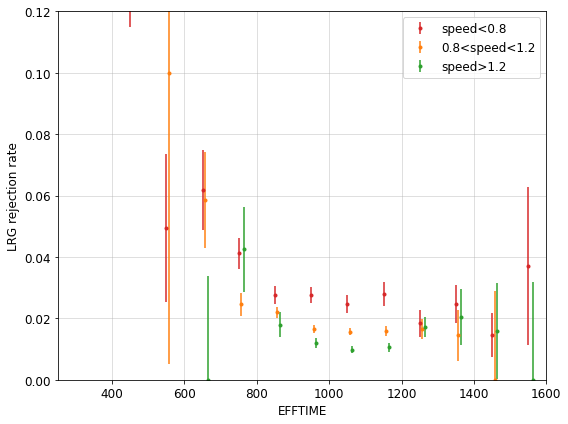

In [32]:
low_speed = cat['speed']<=0.8
print(np.sum(low_speed), np.sum(low_speed)/len(low_speed))

nominal_speed = (cat['speed']>0.8) & (cat['speed']<=1.2)
print(np.sum(nominal_speed), np.sum(nominal_speed)/len(nominal_speed))

high_speed = cat['speed']>1.2
print(np.sum(high_speed), np.sum(high_speed)/len(high_speed))

plt.figure(figsize=(8, 6))

mask = low_speed.copy()
bin_edges = np.linspace(0, 2000, 21)
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(cat['EFFTIME_LRG'][mask], (~mask_quality)[mask], bin_edges, minsize=10)
plt.errorbar(bin_center, bin_reject_rate, color='C3',
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label='speed<0.8')
# plt.hist(cat['EFFTIME_LRG'][mask], bins=bin_edges, weights=np.full(np.sum(mask), 0.2*1/np.sum(mask)), alpha=0.3, color='C3')

mask = nominal_speed.copy()
bin_edges = np.linspace(0, 2000, 21)
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(cat['EFFTIME_LRG'][mask], (~mask_quality)[mask], bin_edges, minsize=10)
plt.errorbar(bin_center+7, bin_reject_rate, color='C1',
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label='0.8<speed<1.2')
# plt.hist(cat['EFFTIME_LRG'][mask], bins=bin_edges, weights=np.full(np.sum(mask), 0.2*1/np.sum(mask)), alpha=0.3, color='C1')

mask = high_speed.copy()
bin_edges = np.linspace(0, 2000, 21)
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(cat['EFFTIME_LRG'][mask], (~mask_quality)[mask], bin_edges, minsize=10)
plt.errorbar(bin_center+14, bin_reject_rate, color='C2',
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label='speed>1.2')
# plt.hist(cat['EFFTIME_LRG'][mask], bins=bin_edges, weights=np.full(np.sum(mask), 0.2*1/np.sum(mask)), alpha=0.3, color='C2')


plt.xlabel('EFFTIME')
plt.ylabel('LRG rejection rate')
plt.grid(alpha=0.5)
plt.legend(loc='upper right')
# plt.title('Main LRGs')
plt.axis([250, 1600, 0, 0.12])
plt.tight_layout()
# plt.savefig('/Users/rongpu/git/desi-targets/lrg_paper/figures/main_failure_rate_vs_efftime.pdf')
plt.show()

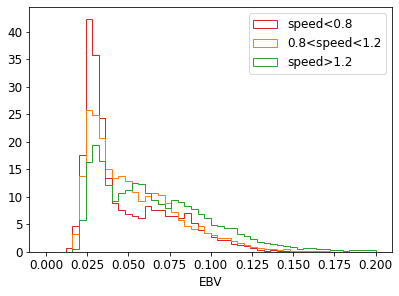

In [33]:
plt.figure(figsize=(6.5, 4.5))
plt.hist(cat['EBV'][low_speed], 50, range=(0, 0.2), alpha=1., density=True, histtype='step', color='C3', label='speed<0.8')
plt.hist(cat['EBV'][nominal_speed], 50, range=(0, 0.2), alpha=1., density=True, histtype='step', color='C1', label='0.8<speed<1.2')
plt.hist(cat['EBV'][high_speed], 50, range=(0, 0.2), alpha=1., density=True, histtype='step', color='C2', label='speed>1.2')
plt.xlabel('EBV')
plt.legend()
plt.show()